In [9]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams.update({'font.size': 12})
pylab.rcParams.update({'font.family': 'sans serif'})
pylab.rcParams.update({'mathtext.default':'regular'})
pylab.rcParams.update({'mathtext.fontset':'stixsans'})
pylab.rcParams.update({'axes.linewidth': 1.5})
pylab.rcParams.update({'xtick.direction':'in'})
pylab.rcParams.update({'xtick.major.size': 5})
pylab.rcParams.update({'xtick.major.width': 1.25 })
pylab.rcParams.update({'xtick.minor.size': 2.5})
pylab.rcParams.update({'xtick.minor.width': 1.25 })
pylab.rcParams.update({'ytick.direction':'in'})
pylab.rcParams.update({'ytick.major.size': 5})
pylab.rcParams.update({'ytick.major.width': 1.25 })
pylab.rcParams.update({'ytick.minor.size': 2.5})
pylab.rcParams.update({'ytick.minor.width': 1.25 })

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


# Constants and Initial Values

In [10]:
# conversion factors to get CGS units into Cholla units
MP = 1.6726E-24;  # proton mass in grams
KB = 1.380658e-16; # Boltzmann constant
LENGTH_UNIT = 3.08567758e21; # kpc in cm
TINY_NUMBER = 1.0e-20;
MASS_UNIT = 1.98855e33; # solar mass in grams
TIME_UNIT = 3.15569e10; # kyr in s
DENSITY_UNIT = (MASS_UNIT/(LENGTH_UNIT*LENGTH_UNIT*LENGTH_UNIT)); 
VELOCITY_UNIT = (LENGTH_UNIT/TIME_UNIT);
PRESSURE_UNIT = (DENSITY_UNIT*VELOCITY_UNIT*VELOCITY_UNIT);

"""this notebook uses the total gas metallicity instead of breaking contributions up by species"""
# solar abundances (percentage of total mass)
# O, C, N, Si, Mg, Ne, Fe, S
metals = np.array([0.0097, 0.0040, 0.00096, 0.00099, 0.00076, 0.00058, 0.0014, 0.00040]);
metallicity = np.sum(metals)

# gas density assuming number density of n ~ 10^-2 and composition of all hydrogen
n = 1e-2 # gas number density
d0_gas = MP * n * LENGTH_UNIT ** 3 / MASS_UNIT
d0_metal = metallicity * d0_gas
# assume 1% dust to gas fraction
d0_dust = d0_gas / 100
print("Gas inital density: {:.5E} M_sun/kpc^3".format(d0_gas))
print("Metal initial density: {:.5E} M_sun/kpc^3".format(d0_metal))
print("Dust inital density: {:.5E} M_sun/kpc^3".format(d0_dust))

# time array and range of temperatures for plotting analytic solutions
t_arr = np.logspace(0, 8, 1000)

T0_cells = [10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8]
T_colors = ["lightskyblue", "violet", "forestgreen", "darkviolet", "thistle", "cadetblue", 
            "palegoldenrod", "darksalmon", "indigo"]

Gas inital density: 2.47120E+05 M_sun/kpc^3
Metal initial density: 4.64338E+03 M_sun/kpc^3
Dust inital density: 2.47120E+03 M_sun/kpc^3


In [11]:
# object that uses forward-Euler to integrate dust sputtering DE
class SputteringIntegrator:
    # conversion factors to get CGS units into Cholla units
    MP = 1.6726E-24;  # proton mass in grams
    KB = 1.380658e-16; # Boltzmann constant
    LENGTH_UNIT = 3.08567758e21; # kpc in cm
    TINY_NUMBER = 1.0e-20;
    MASS_UNIT = 1.98855e33; # solar mass in grams
    TIME_UNIT = 3.15569e10; # kyr in s
    DENSITY_UNIT = (MASS_UNIT/(LENGTH_UNIT*LENGTH_UNIT*LENGTH_UNIT)); 
    VELOCITY_UNIT = (LENGTH_UNIT/TIME_UNIT);
    PRESSURE_UNIT = (DENSITY_UNIT*VELOCITY_UNIT*VELOCITY_UNIT);
    
    def __init__(self, T, n, dt):
        self.T = T
        self.n = n
        self.dt = dt
        self._d0_gas, self._d0_dust = self.calc_init_density()
        self.d_gas, self.d_dust = self.calc_init_density()
        self.tau_sp = self.calc_tau_sp()
        self.type = "Sputtering"

    def calc_tau_sp(self):
        a1 = 3;
        d0 = 1;
        T_0 = 2e6;
        omega = 2.5;
        A = 1.7e8; # 0.17 Gyr
        
        tau_sp = A * (a1/d0) * ((T_0/self.T) ** omega + 1);
        
        return tau_sp
    
    def calc_init_density(self):
        d0_gas = self.MP * self.n * self.LENGTH_UNIT ** 3 / self.MASS_UNIT
        # assume 1% dust to gas fraction
        d0_dust = d0_gas / 100
        
        return d0_gas, d0_dust
    
    def calc_d_dust(self):
        dd_dt = self.calc_dd_dt()
        d_dust_i = self.d_dust + self.dt * dd_dt
        
        return d_dust_i
        
    def calc_dd_dt(self):
        dd_dt = -self.d_dust/(self.tau_sp/3)
        
        return dd_dt
    
    def update_densities(self):
        dd_dt = self.calc_dd_dt()
        self.d_dust += self.dt * dd_dt
    
    def get_info(self):
        print("Sputtering")
        print("------------------------------------------")
        print("Gas temperature: {:.1E} K".format(self.T))
        print("Gas initial density: {:.5E} M_sun/kpc^3".format(self._d0_gas))
        print("Growth timescale: {:.5E} kyr".format(self.tau_sp))
        print("Time-step: {} yr".format(self.dt))
        print("------------------------------------------")

In [17]:
# analytic solution to sputtering DE
def thermal_sputtering(t, T, d0_dust):
    a1 = 3; # dust grain size
    d0 = 1; # gas density
    T_0 = 2e6;
    omega = 2.5;
    A = 1.7e8; # units: kyr
    
    tau_sp = A * (a1/d0) * ((T_0/T) ** omega + 1);
    
    return d0_dust * np.exp(-3*t/tau_sp)

In [18]:
def evolve_solutions(h, n, T_arr, T_colors):
    t_arr = np.arange(0, 1e7, h)
    
    d_dust = np.zeros(shape=(len(T_arr), len(t_arr)))
    integrator = None
    
    def time_refine(integrator):
        d_dust_i = integrator.calc_d_dust()
        dd_dt = integrator.calc_dd_dt()
        dt = integrator.dt
        dd = dd_dt * dt
        while dd/d_dust_i > 0.01:
            dt_sub = 0.01 * d_dust_i / dd_dt

            integrator.d_dust += dt_sub * dd_dt
            integrator.dt -= dt_sub
            dt = integrator.dt
            dd_dt = integrator.calc_dd_dt()
            dd = dt * dd_dt

    for j, T in enumerate(T_arr):
        integrator = SputteringIntegrator(T, n, h)
        integrator.get_info()
        # set initial densities
        # initial conditions are a little wrong I think?
        d_dust[j][0] = integrator._d0_dust

        integrators = [integrator]
        for i, t_i in enumerate(t_arr):
            if (i+1) < len(t_arr):
                for integrator in integrators:
                    d_dust_i = integrator.calc_d_dust()
                    dd_dt = integrator.calc_dd_dt()
                    dd = integrator.dt * dd_dt

                    # if rate of dust growth is changing too rapidly
                    if dd/d_dust_i > 0.01:
                        # shorten time-step
                        time_refine(integrator)
                        integrator.dt = h
                        d_dust[j][i+1] = integrator.d_dust
                        continue

                    integrator.update_densities()
                    d_dust[j][i+1] = integrator.d_dust
                    
    return d_dust

In [19]:
T_arr = [10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8]
T_colors = ["lightskyblue", "violet", "forestgreen", "darkviolet", "thistle", "cadetblue", 
            "palegoldenrod", "darksalmon", "indigo"]

h = 10
n = 1e-2

dd = evolve_solutions(h, n, T_arr, T_colors)

Sputtering
------------------------------------------
Gas temperature: 1.0E+01 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 9.12316E+21 kyr
Time-step: 10 yr
------------------------------------------
Sputtering
------------------------------------------
Gas temperature: 1.0E+02 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 2.88500E+19 kyr
Time-step: 10 yr
------------------------------------------
Sputtering
------------------------------------------
Gas temperature: 1.0E+03 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 9.12316E+16 kyr
Time-step: 10 yr
------------------------------------------
Sputtering
------------------------------------------
Gas temperature: 1.0E+04 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 2.88500E+14 kyr
Time-step: 10 yr
------------------------------------------
Sputtering
------------------------------------------
Gas temperature: 1.0E+05 K
Gas initial density: 2.47120E+05 M_sun/

Text(0.5, 1.0, 'thermal sputtering of dust')

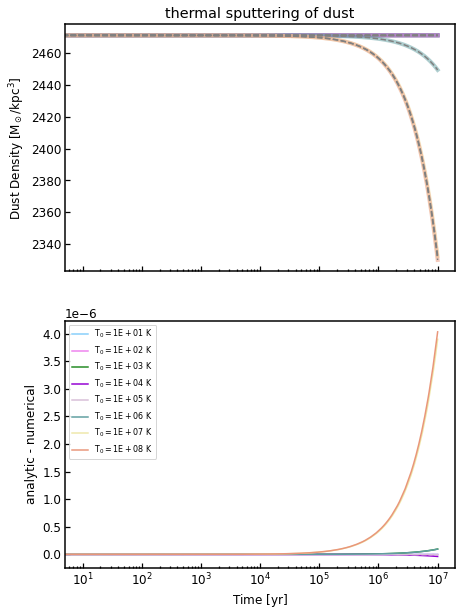

In [20]:
# time step
t_arr = np.arange(0, 1e7, h)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7,10))
for j, T in enumerate(T0_cells):
    ax[0].semilogx(t_arr, dd[j], linestyle="--", color="grey")
    ax[0].semilogx(t_arr, thermal_sputtering(t_arr, T, d0_dust), color=T_colors[j], linewidth=4, alpha=0.5, zorder=0)
    ax[1].semilogx(t_arr, thermal_sputtering(t_arr, T, d0_dust) - dd[j], color=T_colors[j], label=f"$T_0={T:.0E}~K$")
    ax[1].set_xlabel("Time$~[yr]$")
    ax[0].set_ylabel(r"Dust Density$~[M_\odot/kpc^3]$")
    ax[1].set_ylabel("analytic - numerical")
    ax[1].legend(fontsize=8)
ax[0].set_title("thermal sputtering of dust")
# plt.savefig("/Users/helenarichie/GitHub/helenarichie.github.io/assets/img/posts/sputtering_numerical.png", facecolor="white")

Text(0.5, 1.0, 'thermal sputtering of dust')

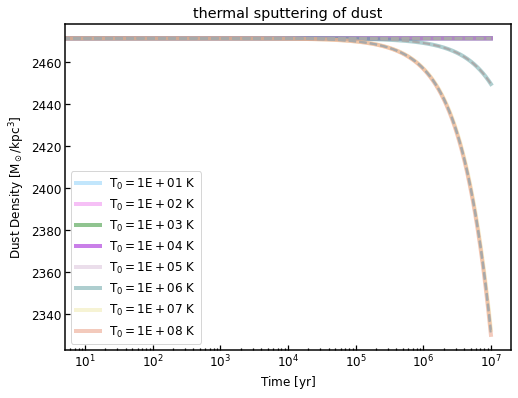

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for j, T in enumerate(T0_cells):
    ax.semilogx(t_arr, dd[j], linestyle="--", linewidth=2, color="darkgrey")
    ax.semilogx(t_arr, thermal_sputtering(t_arr, T, d0_dust), color=T_colors[j], linewidth=4, alpha=0.5, zorder=0, label=f"$T_0={T:.0E}~K$")
    ax.set_xlabel("Time$~[yr]$")
    ax.set_ylabel(r"Dust Density$~[M_\odot/kpc^3]$")
    ax.legend()
ax.set_title("thermal sputtering of dust")
# plt.savefig("/Users/helenarichie/GitHub/helenarichie.github.io/assets/img/posts/sputtering_numerical.png", facecolor="white")